In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
figsize(10, 8)

In [4]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [5]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [6]:
from astropy import coordinates
from astropy import units 

In [7]:
c = coordinates.SkyCoord(l=107.2*units.degree, b=5.2*units.degree, frame='galactic')

In [8]:
c.galactic.l

<Longitude 107.2 deg>

In [9]:
c.galactic.b

<Latitude 5.2 deg>

In [10]:
c.icrs.ra.deg

335.7133441444117

In [11]:
c.icrs.dec.deg

63.43802542905474

In [12]:
rc = 335.7133441444117
dc = 63.43802542905474

In [13]:
def get_map(bank='A', session='5', doplot=True, pixbeam=4.):
    rc = 335.7134
    dc = 63.4380
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/datamaps_'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units !!
    # units now are Jy * beam area per pixel area
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    signal = gaussian_filter(signal, beam/pixbeam)
    shits = gaussian_filter(hits, beam/pixbeam)
    signal[mask] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(rabins, decbins, signal)
        clim(-0.1*units, 0.1*units)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Flux [Jy]')
    
    return signal, ras, decs, rabins, decbins

/usr/lib64/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


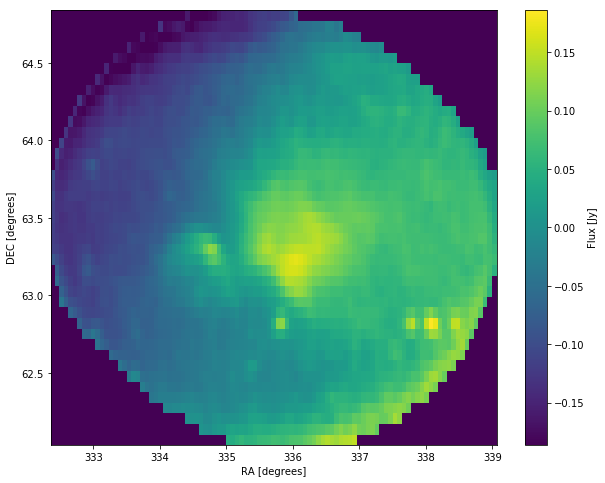

In [14]:
signal, ras, decs, rabins, decbins = get_map()

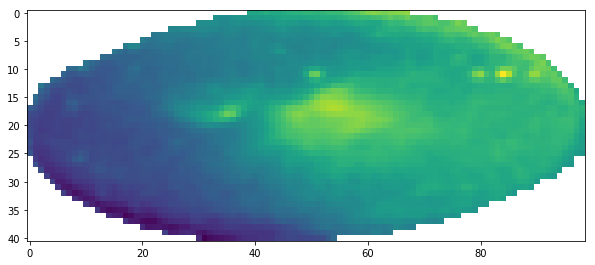

In [15]:
imshow(signal)

In [16]:
rabinsc = (rabins[1:] + rabins[:-1]) / 2.
decbinsc = (decbins[1:] + decbins[:-1]) / 2.

In [17]:
rdmesh = meshgrid(rabinsc, decbinsc)

In [87]:
radius_grid = np.sqrt( (rdmesh[0] - rc)**2 + (rdmesh[1] - dc)**2 ) 

In [102]:
quadI = (rdmesh[0] > rc ) * (rdmesh[1] > dc)

In [103]:
quadII = (rdmesh[0] < rc ) * (rdmesh[1] > dc)

In [104]:
quadIII = (rdmesh[0] < rc ) * (rdmesh[1] < dc)

In [105]:
quadIV = (rdmesh[0] > rc ) * (rdmesh[1] < dc)

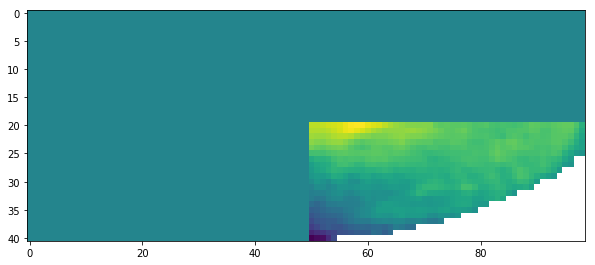

In [109]:
test = np.zeros([41, 99])
test[quadI] = signal[quadI]
imshow(test)

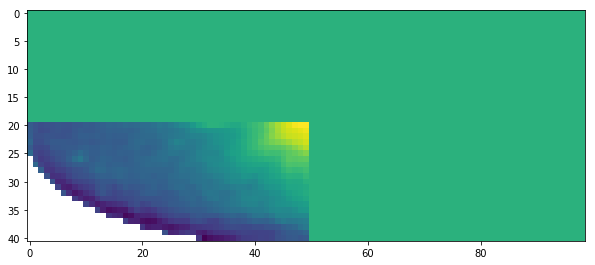

In [110]:
test = np.zeros([41, 99])
test[quadII] = signal[quadII]
imshow(test)

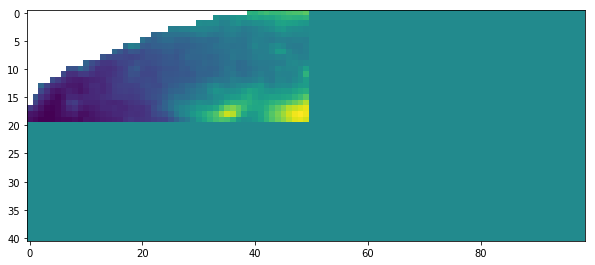

In [111]:
test = np.zeros([41, 99])
test[quadIII] = signal[quadIII]
imshow(test)

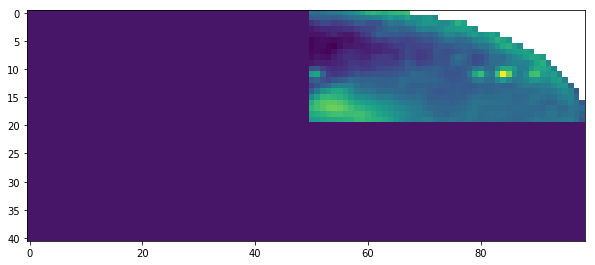

In [112]:
test = np.zeros([41, 99])
test[quadIV] = signal[quadIV]
imshow(test)

In [115]:
rsigI = signal[quadI]
rI = radius_grid[quadI]

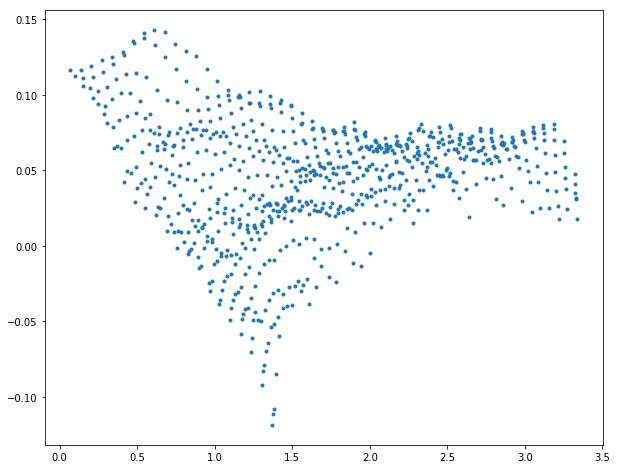

In [119]:
plot(rI, rsigI, '.')

In [120]:
rsigII = signal[quadII]
rII = radius_grid[quadII]

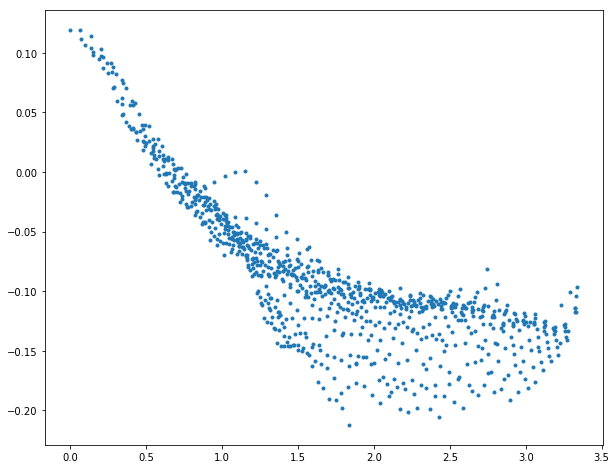

In [121]:
plot(rII, rsigII, '.')

In [122]:
rsigIII = signal[quadIII]
rIII = radius_grid[quadIII]

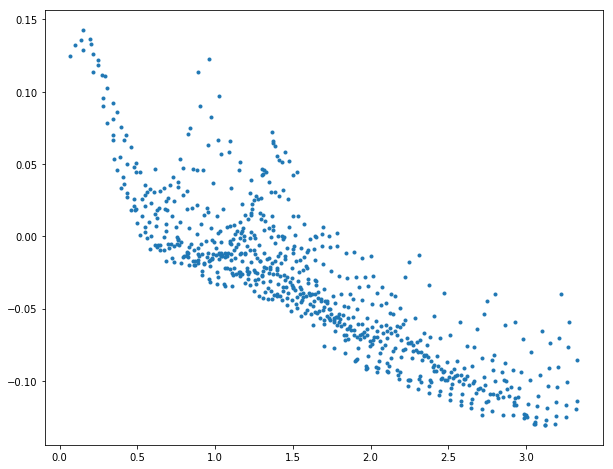

In [123]:
plot(rIII, rsigIII, '.')

In [124]:
rsigIV = signal[quadIV]
rIV = radius_grid[quadIV]

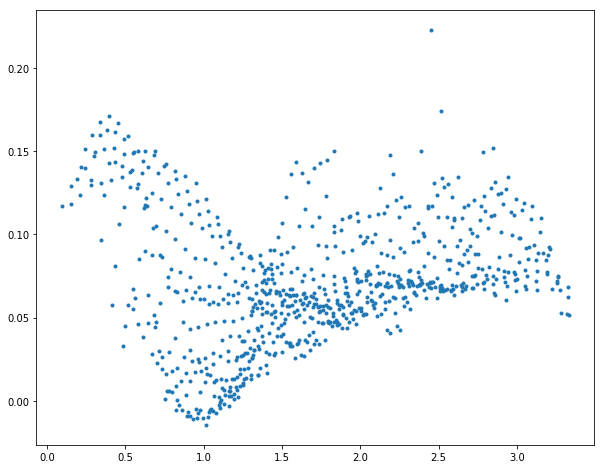

In [125]:
plot(rIV, rsigIV, '.')

In [136]:
x = zip(rI, rsigI)
x.sort()
rIsort, rsigIsort = zip(*x)
rIsort = np.array(rIsort)
rsigIsort = np.array(rsigIsort)
maskI = ~np.isnan(rsigIsort)
rfluxI = np.cumsum(rsigIsort[maskI])

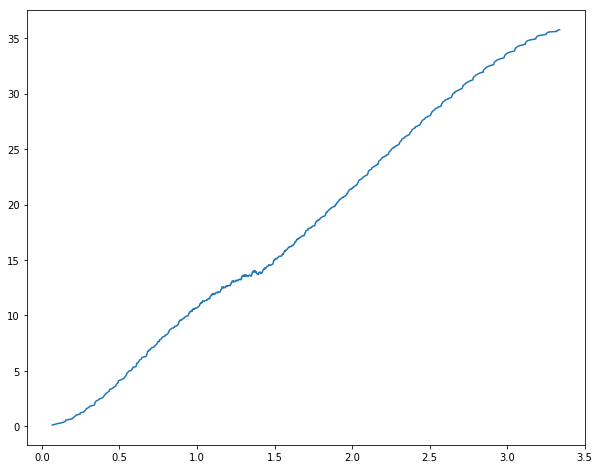

In [138]:
plot(rIsort[maskI], rfluxI)

In [134]:
x = zip(rII, rsigII)
x.sort()
rIIsort, rsigIIsort = zip(*x)
rIIsort = np.array(rIIsort)
rsigIIsort = np.array(rsigIIsort)
maskII = ~np.isnan(rsigIIsort)
rfluxII = np.cumsum(rsigIIsort[maskII])

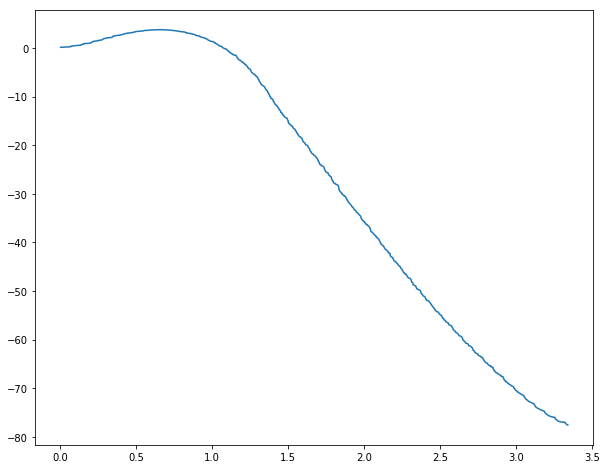

In [135]:
plot(rIIsort[maskII], rfluxII)

In [139]:
x = zip(rIII, rsigIII)
x.sort()
rIIIsort, rsigIIIsort = zip(*x)
rIIIsort = np.array(rIIIsort)
rsigIIIsort = np.array(rsigIIIsort)
maskIII = ~np.isnan(rsigIIIsort)
rfluxIII = np.cumsum(rsigIIIsort[maskIII])

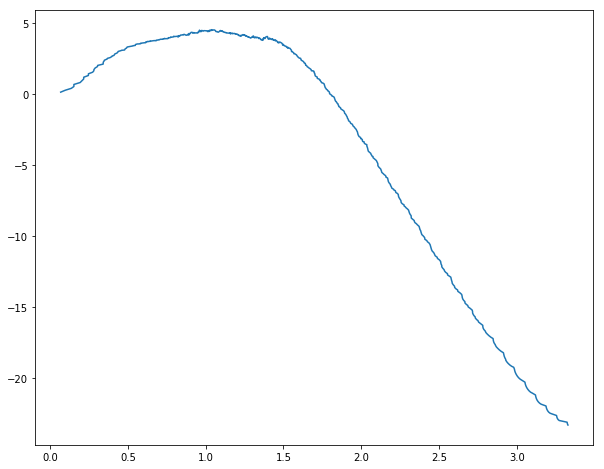

In [140]:
plot(rIIIsort[maskIII], rfluxIII)

In [141]:
x = zip(rIV, rsigIV)
x.sort()
rIVsort, rsigIVsort = zip(*x)
rIVsort = np.array(rIVsort)
rsigIVsort = np.array(rsigIVsort)
maskIV = ~np.isnan(rsigIVsort)
rfluxIV = np.cumsum(rsigIVsort[maskIV])

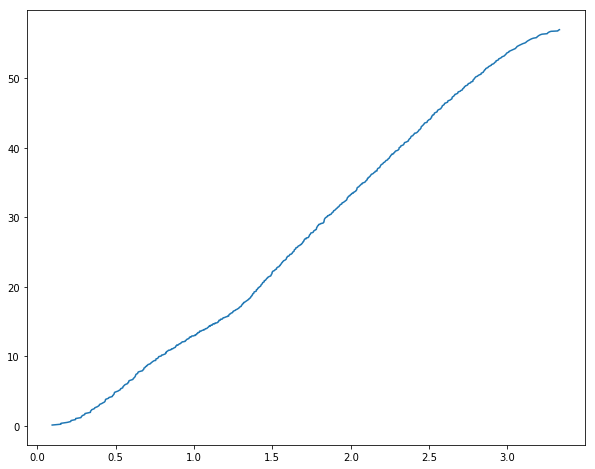

In [142]:
plot(rIVsort[maskIV], rfluxIV)

In [24]:
rsig = signal.reshape(signal.size, )
radius = radius_grid.reshape(signal.size, )

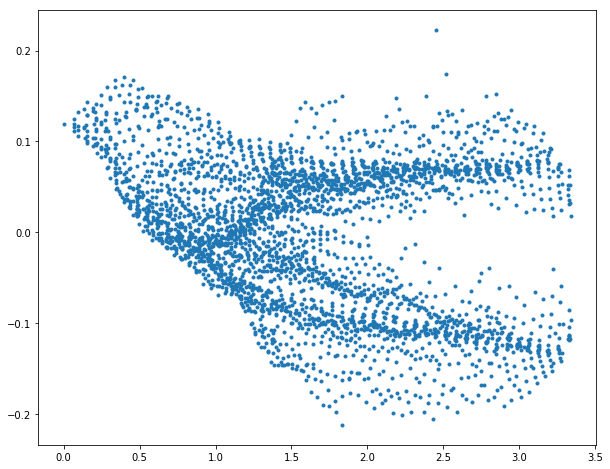

In [25]:
plot(radius, rsig, '.')

In [40]:
x = zip(radius, rsig)

In [41]:
x.sort()

In [42]:
radsort, fluxsort = zip(*x)

In [43]:
radsort = np.array(radsort)
fluxsort = np.array(fluxsort)

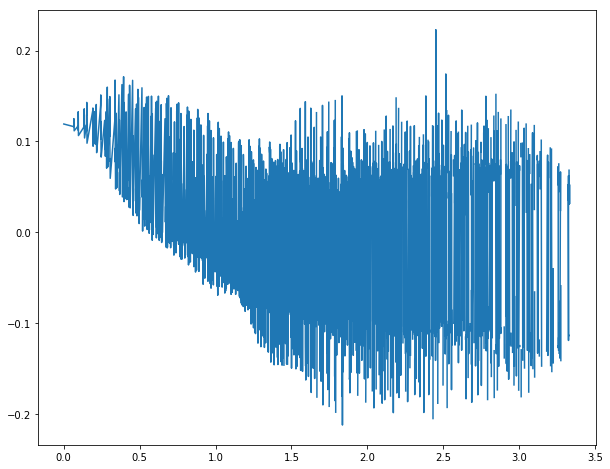

In [44]:
plot(radsort, fluxsort)

In [45]:
np.isnan(fluxsort)

array([False, False, False, ...,  True,  True,  True], dtype=bool)

In [46]:
amask = (radsort > 80./60.) * (radsort < 2. ) 

In [47]:
np.nanmedian(fluxsort[amask])

-0.0031504499033931971

In [48]:
np.nanmean(fluxsort[amask])

-0.01254459677735935

In [49]:
rmask = radsort < 1. 

In [50]:
np.nansum(fluxsort[rmask])

29.3509645548015

In [51]:
np.nansum(fluxsort[rmask] - np.nanmedian(fluxsort[amask]))

31.471217339785124

In [52]:
np.nansum(fluxsort[rmask] - np.nanmean(fluxsort[amask]))

37.793478185964346

In [53]:
mask = np.isnan(fluxsort)
fluxsort[mask] = 0.

In [54]:
intflux = np.cumsum(fluxsort + 0.01254459677735935)

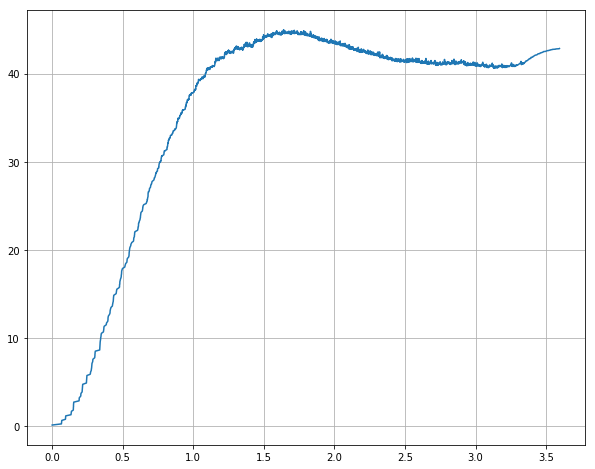

In [55]:
plot(radsort, intflux)
grid()